# 10章

BERTにトークン化された文章を入力することで、各トークンに対するベクトルが出力される。トークンごとのベクトルを集約することで、文章をベクトルとして特徴づけることができる。これを文章ベクトルと呼ぶ。<br>
適切に学習されたモデルから得られる文章ベクトルは、文章の意味をなんらかのかたちで反映していると考えられる。

ここでは、文章ベクトルを利用して文章の意味的な可視化と、類似文章検索を行う。

In [3]:
# 10-3

import random
import glob
from tqdm import tqdm
import numpy as np
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

まずはデータをダウンロードする。データは、6章で使用したlivedoorコーパスを用いる。

In [4]:
os.makedirs("data/chapter6", exist_ok=True)

In [6]:
# 10-4

!curl -o "data/chapter6/ldcc.tar.gz" "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
!cd "data/chapter6" && tar -zxf "ldcc.tar.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8647k  100 8647k    0     0  85538      0  0:01:43  0:01:43 --:--:--  247k31k      0  0:01:05  0:00:10  0:00:55 5790513  0:00:33  461k


まず、それぞれの記事のカテゴリを0〜8の数字で表したラベルに変換し、それぞれの記事から文章ベクトルを計算する。

In [7]:
# 10-5

category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

# トークナイザとモデルのロード
model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model = model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
# データの形式を整える
max_length = 256
sentence_vectors = []
labels_lst = []
for label, category in enumerate(tqdm(category_list)):
    for file_path in glob.glob(f"data/chapter6/text/{category}/{category}-*.txt"):
        # 記事から文章を抜き出し符号化する
        
        lines = open(file_path).read().splitlines()
        text = "\n".join(lines[3:]) # 本文は4行目から
        encoding = tokenizer(
            text, 
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        encoding = {key: value.cuda() for key, value in encoding.items()}
        attention_mask = encoding['attention_mask']

        # BERTの最終層の出力の平均から文章ベクトルを計算
        with torch.no_grad():
            output = model(**encoding)
        last_hidden_state = output.last_hidden_state # (1, 256, 768)の三次元

        # last_hidden_state (1, 256, 768) に
        # attention_mask (1, 256) -> (1, 256, 1) に次元追加したものを掛ける
        # →attention_mask を適用する
        tmp = last_hidden_state * attention_mask.unsqueeze(axis=2)
        # 平均値を取る (1, 768) / (1, 1) -> 
        average_hidden_state = tmp.sum(axis=1) / torch.sum(attention_mask, axis=1, keepdim=True)

        # sentence_vectorsをvstackするため[0]で次元を削っておく
        sentence_vectors.append(average_hidden_state[0].cpu().numpy())
        labels_lst.append(label)

sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels_lst)

100%|██████████| 9/9 [01:11<00:00,  7.91s/it]


## 10.4 文章コーパスの可視化

主成分分析やt-SNEによって次元圧縮をする

### 10.4.1 主成分分析

In [61]:
# 10-6

pca = PCA(n_components=2)
sentence_vectors_pca = pca.fit_transform(sentence_vectors)

In [62]:
sentence_vectors_pca.shape

(7367, 2)

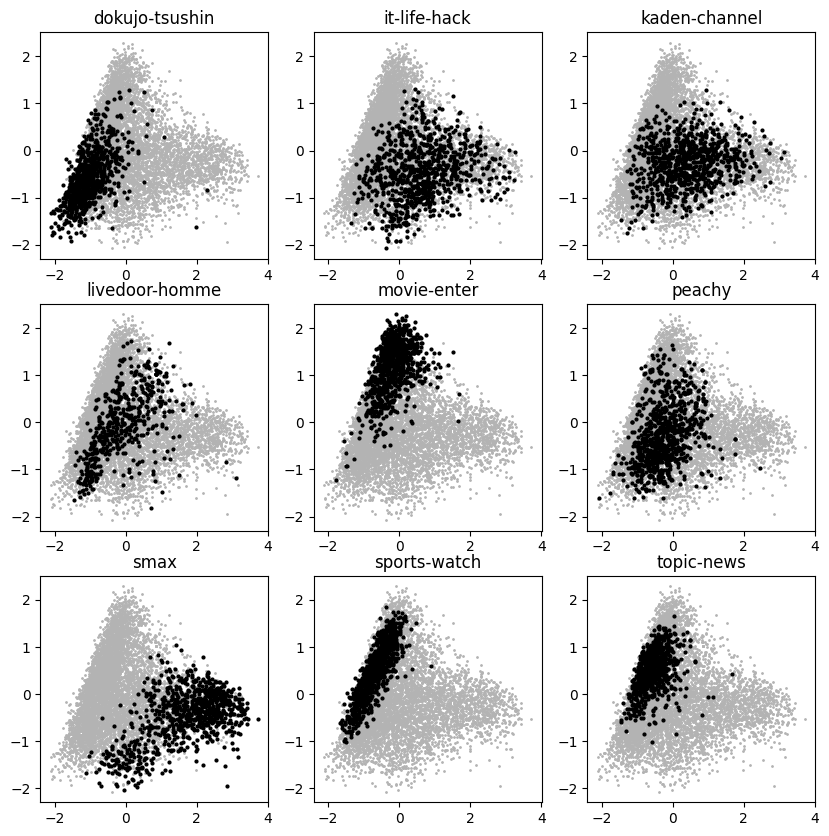

In [63]:
# 10-7
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_pca[:,0], 
        sentence_vectors_pca[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0], 
        sentence_vectors_pca[index,1], 
        'o', 
        markersize=2, 
        color='k'
    )
    plt.title(category_list[label])

同じカテゴリの記事の文章ベクトルはクラスターを形成しており、内容が近い文章は文章ベクトルも似ていることが示唆された。<br>
一方で、上図ではカテゴリごとに分布のオーバーラップが認められる。このオーバーラップが、同じような分布のカテゴリの文章ベクトルが似ていることによるのか、主成分分析による次元圧縮の結果なのかは不明である。

### 10.4.2 t-SNE

In [64]:
# 10-8

tsne = TSNE(n_components=2)
sentence_vectors_tsne = tsne.fit_transform(sentence_vectors)

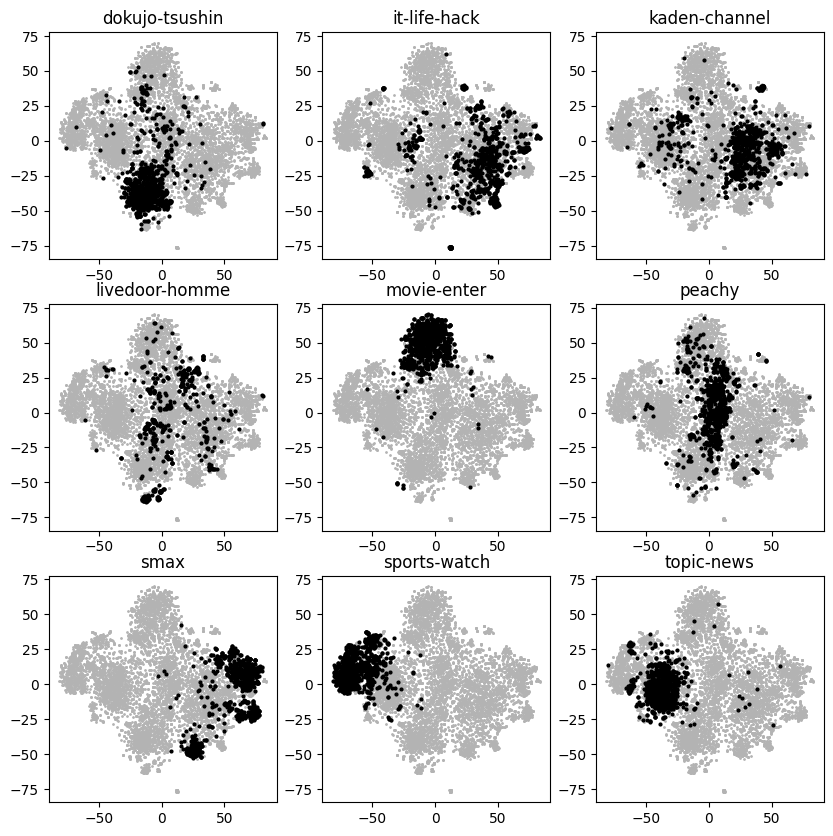

In [65]:
# 10-9
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1], 
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

## 10.5 類似文章検索

In [ ]:
# 10-10
# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True) 
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(axis=1) 

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")